In [1]:
import matplotlib.pyplot as plt
import numpy as np
import requests
import xarray as xr
from matplotlib.colors import LogNorm
from matplotlib.pyplot import fill_between
from scipy.signal import stft
import zarr
from statsmodels.sandbox.distributions.try_pot import mean_residual_life

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

from statsmodels.tsa.arima_process import ArmaProcess, arma_acovf, arma_acf, arma_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acovf, acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.holtwinters import ExponentialSmoothing

from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit

import pmdarima as pm

In [3]:
import scienceplots
plt.style.use('science')
plt.rcParams.update({
    'text.usetex': True,
    'text.latex.preamble': r'\usepackage[T1]{fontenc} \usepackage{polski} \usepackage[utf8]{inputenc}'
})
figsize = (6, 3)
linewidth = 0.5
linewidth_time_series = 0.3

In [4]:
shot_data = requests.get("https://mastapp.site/json/shots/30421").json()
endpoint, url = shot_data["endpoint_url"], shot_data["url"]
shot_url = url.replace("s3:/", endpoint)

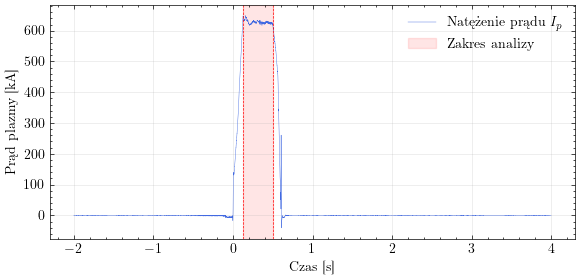

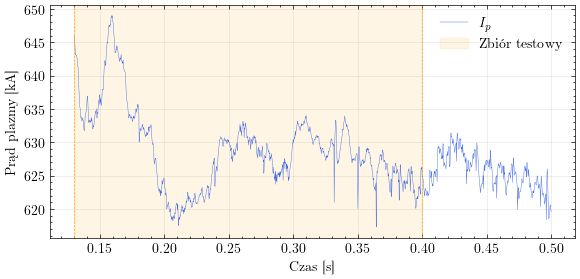

In [21]:
dataset = xr.open_zarr(shot_url, group='amc', storage_options={'ssl': False})
# dataset = dataset.isel(time=(dataset.time > 0) & (dataset.time < .35))
dataset = dataset.isel()
ts_full = dataset['plasma_current'].to_series()

start_cut = 0.13
end_cut = 0.5
test_end_cut = 0.4
mast_data_full = ts_full[(ts_full.index > start_cut) & (ts_full.index < end_cut)]
mast_data = ts_full[(ts_full.index > start_cut) & (ts_full.index < test_end_cut)]

# RYSUNEK 1: Cały przebieg z zaznaczonym wycinkiem
plt.figure(figsize=figsize)
plt.plot(dataset['time'], dataset['plasma_current'], label='Natężenie prądu $I_p$', color='royalblue', linewidth=linewidth_time_series)

plt.axvline(x=start_cut, color='red', linestyle='--', linewidth=linewidth)
plt.axvline(x=end_cut, color='red', linestyle='--', linewidth=linewidth)
plt.axvspan(start_cut, end_cut, color='red', alpha=0.1, label='Zakres analizy')

plt.xlabel("Czas [s]")
plt.ylabel("Prąd plazmy [kA]")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("latex/figures/figure1.pdf")
plt.show()

# RYSUNEK 2: Tylko ten wycinek ze zbiorem testowym (mast_data)
plt.figure(figsize=figsize)
plt.plot(mast_data_full, color='royalblue', linewidth=linewidth_time_series, label='$I_p$')

plt.axvline(x=start_cut, color='orange', linestyle='--', linewidth=linewidth)
plt.axvline(x=test_end_cut, color='orange', linestyle='--', linewidth=linewidth)
plt.axvspan(start_cut, test_end_cut, color='orange', alpha=0.1, label='Zbiór testowy')

plt.xlabel("Czas [s]")
plt.ylabel("Prąd plazmy [kA]")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig("latex/figures/figure2.pdf")
plt.show()


---
# ACF, PACF
---

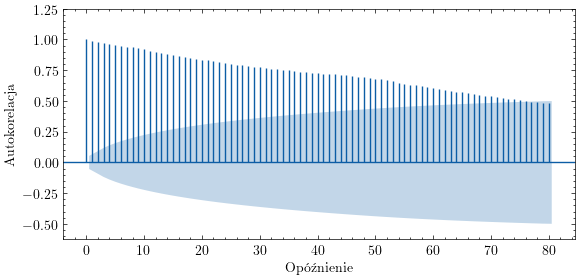

In [6]:
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)

plot_acf(mast_data, lags=80, ax=ax, marker="", auto_ylims=True)
ax.set_xlabel('Opóźnienie')
ax.set_ylabel('Autokorelacja')
ax.set_title('')

plt.tight_layout()
plt.savefig("latex/figures/empiryczna_acf_surowe.pdf")


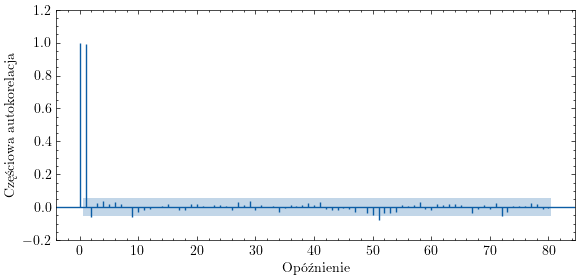

In [7]:
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)

plot_pacf(mast_data, lags=80, ax=ax, marker="", auto_ylims=True)
ax.set_xlabel('Opóźnienie')
ax.set_ylabel('Częściowa autokorelacja')
ax.set_title('')
ax.set_ylim(-0.2, 1.2)

plt.tight_layout()
plt.savefig("latex/figures/empiryczna_pacf_surowe.pdf")


---
# dekompozycja
---

### sezonowos czyli pulsowanie cewki plazmowej??

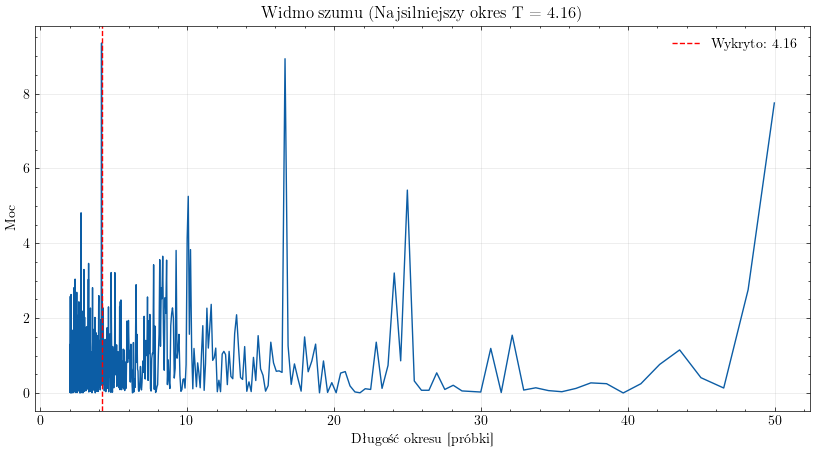

In [8]:
from scipy.signal import periodogram

# Bierzemy różnicę (żeby usunąć wolny trend i zobaczyć tylko szybkie tętnienia)
data_diff = mast_data.diff().dropna()

# Obliczamy periodogram dla danych BEZ trendu
fs = 1.0 # Zakładamy próbkowanie 1 (wynik w cyklach na próbkę)
freqs, power = periodogram(data_diff.values, fs=fs)

# Szukamy piku, ale TYLKO w zakresie krótkich okresów (tzw. wysokie częstotliwości)
# Interesują nas okresy od 2 do 50 próbek (tam żyją tętnienia zasilania)
# Przeliczamy okresy na indeksy tablicy (trochę matematyki indeksowej)
valid_mask = (freqs > 1/50) & (freqs < 1/2) # Zakres f: od 0.02 do 0.5
freqs_zoom = freqs[valid_mask]
power_zoom = power[valid_mask]

# Znajdujemy najsilniejszy pik w tym zakresie
max_idx = np.argmax(power_zoom)
dominant_freq = freqs_zoom[max_idx]
exact_period = 1 / dominant_freq

plt.figure(figsize=(10, 5))
plt.plot(1/freqs_zoom, power_zoom)
plt.title(f"Widmo szumu (Najsilniejszy okres T = {exact_period:.2f})")
plt.xlabel("Długość okresu [próbki]")
plt.ylabel("Moc")
plt.axvline(x=exact_period, color='r', linestyle='--', label=f'Wykryto: {exact_period:.2f}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

period = int(exact_period)

### Dekompozycja szeregu czasowego - przykład 2

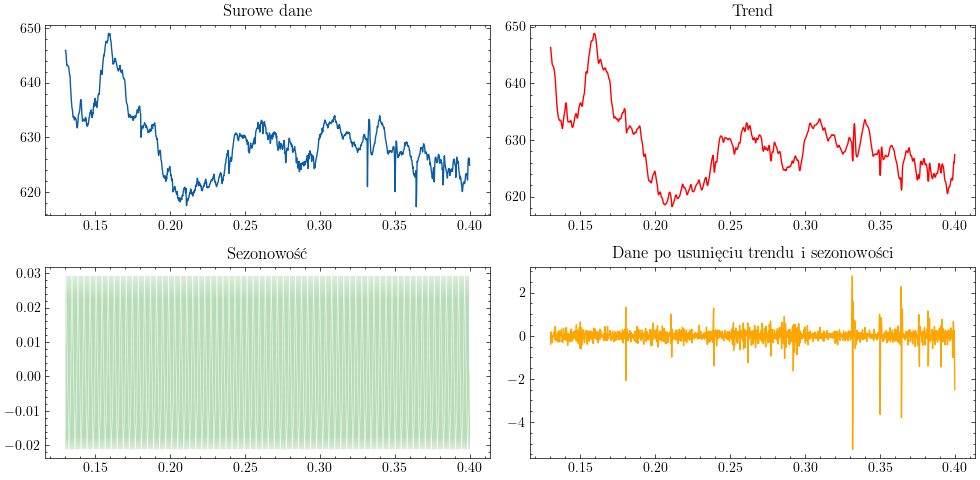

In [9]:
decomposition = seasonal_decompose(mast_data, model='additive', period=period, extrapolate_trend=1)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(10, 5))

plt.subplot(2, 2, 1)
plt.plot(mast_data, label='Original')
plt.title('Surowe dane')

plt.subplot(2, 2, 2)
plt.plot(trend, label='Trend', color='red')
plt.title('Trend')

plt.subplot(2, 2, 3)
plt.plot(seasonal, label='Seasonal', color='green', linewidth=0.1)
plt.title('Sezonowość')

plt.subplot(2, 2, 4)
plt.plot(residual, label='Residual', color='orange')
plt.title('Dane po usunięciu trendu i sezonowości')

plt.tight_layout()
plt.show()

In [10]:
### Dekompozycja szeregu czasowego - przykład 3

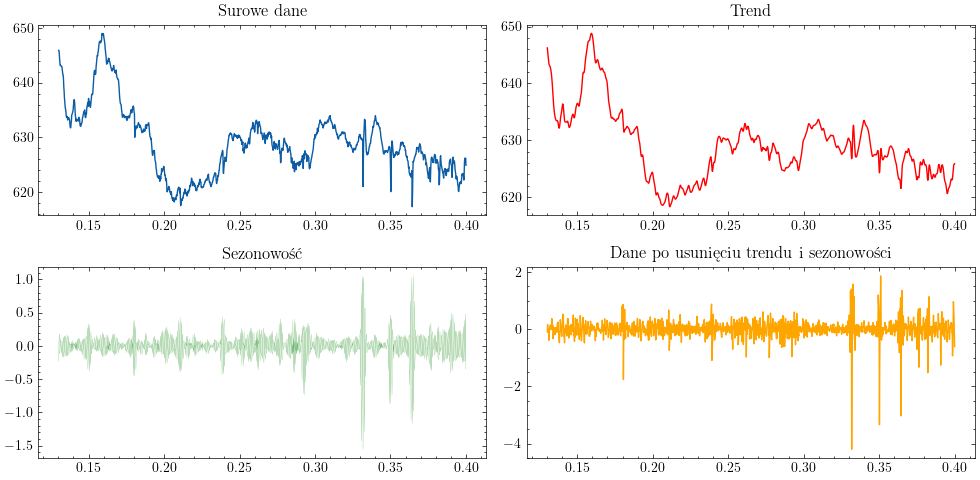

In [11]:
# https://otexts.com/fpp2/stl.html

stl_decomposition = STL(mast_data, period=period).fit()

trend_stl = stl_decomposition.trend
seasonal_stl = stl_decomposition.seasonal
residual_stl = stl_decomposition.resid

plt.figure(figsize=(10, 5))

plt.subplot(2, 2, 1)
plt.plot(mast_data, label='Original')
plt.title('Surowe dane')

plt.subplot(2, 2, 2)
plt.plot(trend_stl, label='Trend', color='red')
plt.title('Trend')

plt.subplot(2, 2, 3)
plt.plot(seasonal_stl, label='Seasonal', color='green', linewidth=0.1)
plt.title('Sezonowość')

plt.subplot(2, 2, 4)
plt.plot(residual_stl, label='Residual', color='orange')
plt.title('Dane po usunięciu trendu i sezonowości')

plt.tight_layout()
plt.show()

### Dekompozycja szeregu czasowego - przykład 4

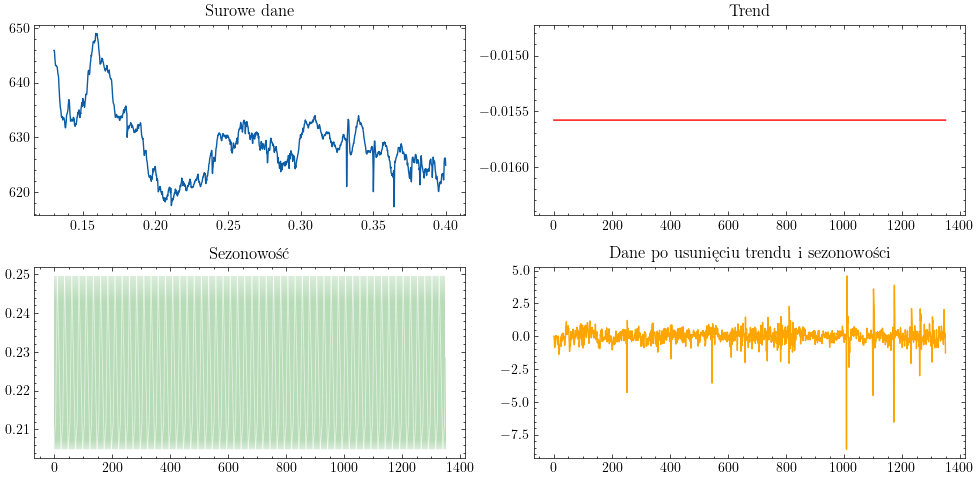

In [12]:
# https://otexts.com/fpp2/holt-winters.html

ets_model = ExponentialSmoothing(mast_data.values, seasonal_periods=period, trend='add', seasonal='add').fit()

trend_ets = ets_model.trend
seasonal_ets = ets_model.season
residual_ets = ets_model.resid

plt.figure(figsize=(10, 5))

plt.subplot(2, 2, 1)
plt.plot(mast_data, label='Original')
plt.title('Surowe dane')

plt.subplot(2, 2, 2)
plt.plot(trend_ets, label='Trend', color='red')
plt.title('Trend')

plt.subplot(2, 2, 3)
plt.plot(seasonal_ets, label='Seasonal', color='green', linewidth=0.1)
plt.title('Sezonowość')

plt.subplot(2, 2, 4)
plt.plot(residual_ets, label='Residual', color='orange')
plt.title('Dane po usunięciu trendu i sezonowości')

plt.tight_layout()
plt.show()

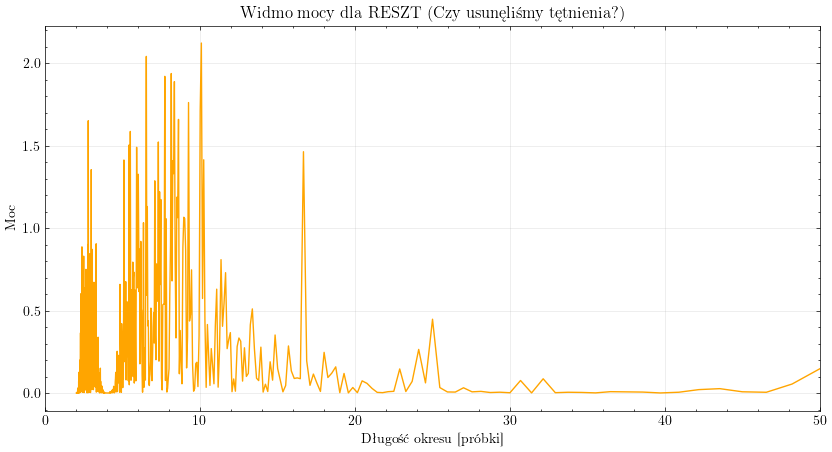

In [13]:
from scipy.signal import periodogram
import matplotlib.pyplot as plt
import numpy as np

residual_clean = residual_stl

# Obliczamy periodogram dla reszt
fs = 1.0
freqs, power = periodogram(residual_clean.values[1:], fs=fs)

plt.figure(figsize=(10, 5))
plt.plot(1/freqs[valid_mask], power[valid_mask], color='orange')

plt.title("Widmo mocy dla RESZT (Czy usunęliśmy tętnienia?)")
plt.xlabel("Długość okresu [próbki]")
plt.ylabel("Moc")
plt.xlim(0, 50)
plt.grid(True, alpha=0.3)
plt.show()

### dekompozycja - empirical mode decomposition

3648.6486486486488


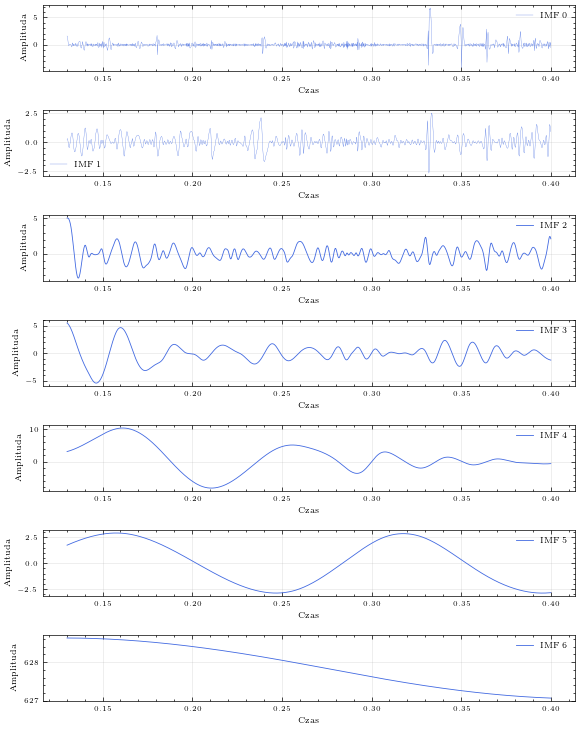

In [14]:
# empirical mode decomposition??
import emd

t = mast_data.index
imf = emd.sift.sift(mast_data.values)
sample_rate = (len(imf)/(end_cut - start_cut))
print(sample_rate)

IP, IF, IA = emd.spectra.frequency_transform(imf, sample_rate, 'hilbert')

# Define frequency range (low_freq, high_freq, nsteps, spacing)
freq_range = (0.1, 10, 80, 'log')
f, hht = emd.spectra.hilberthuang(IF, IA, freq_range, sum_time=False)

plt.figure(figsize=(6, 7.5))
for i in range(imf.shape[1]):
    if i < 2:
        linewidthh = 0.2
    else:
        linewidthh = 0.6
    plt.subplot(imf.shape[1], 1, i + 1)
    plt.plot(t, imf[:, i], color='royalblue', linewidth=linewidthh, label=f"IMF {i}")
    plt.ylabel(f"Amplituda", fontsize=6)
    plt.xlabel("Czas", fontsize=6)
    plt.yticks(fontsize=5)
    plt.xticks(fontsize=5)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=6)
plt.tight_layout()
plt.savefig('mast_data_decomposition.pdf')


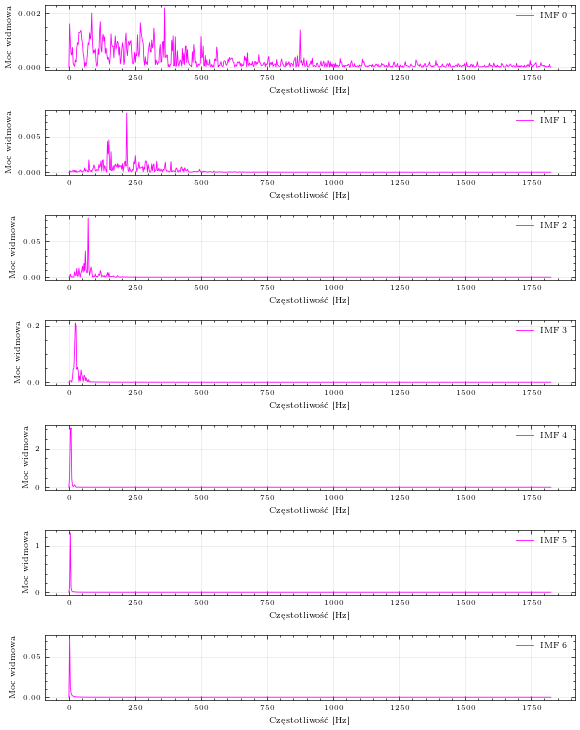

In [15]:
from scipy.signal import periodogram

fs = sample_rate

plt.figure(figsize=(6, 7.5))
for i in range(imf.shape[1]):
    f, Pxx = periodogram(imf[:, i], fs=sample_rate)
    plt.subplot(imf.shape[1], 1, i + 1)
    plt.plot(f, Pxx, color='magenta', label=f"IMF {i}", linewidth=0.6)

    plt.xlabel("Częstotliwość [Hz]", fontsize=6)
    plt.ylabel("Moc widmowa", fontsize=6)
    plt.yticks(fontsize=5)
    plt.xticks(fontsize=5)
    plt.legend(fontsize=6)
    plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('mast_data_decomposition_periodograms.pdf')